In [1]:
import numpy as np
import pandas as pd
from sklearn import datasets, cluster
import matplotlib.pyplot as plt
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

import os, pickle
from time import time
from tqdm import tqdm 
from proj_util import cal_avg_precision, get_user_product_matrix

from sklearn.decomposition import NMF
import scipy

FOLDER_PATH = ''


In [3]:
train_set = pickle.load(open(os.path.join(FOLDER_PATH,'pickle','train_set.p'),'rb'))
validation_set = pickle.load(open(os.path.join(FOLDER_PATH,'pickle','validation_set.p'),'rb'))

user_mapping = pickle.load(open(os.path.join(FOLDER_PATH,'pickle','user_mapping.p'),'rb'))
product_mapping = pickle.load(open(os.path.join(FOLDER_PATH,'pickle','product_mapping.p'),'rb'))

In [4]:
train_set = train_set.drop('order_id',axis=1)

In [5]:
train_set.user_id = train_set.user_id.map(user_mapping)
train_set.product_id = train_set.product_id.map(product_mapping)

validation_set.user_id = validation_set.user_id.map(user_mapping)
validation_set.product_id = validation_set.product_id.map(product_mapping)

## Approach 1

The way we compute the probability of each user-product is as following:

1. We computed, for each User and each Product, the number of orders that contains the Product in the train set. <br>
(e.g. user 1 purchased product 1 in 5 different order --> user1-product1 = 5)

2. We aggregated all the products for each user with Sum.

3. We computed the **ratio of user-product over the user sum** and use that as the probability.

In [8]:
user_product_train = train_set.groupby(['user_id', 'product_id']).size().reset_index().rename(columns={0: 'quantity'})
user_product_train = user_product_train.groupby(['user_id','product_id']).agg({'quantity': 'sum'})
user_product_train = user_product_train.groupby(level=0).apply(lambda x: x/float(x.sum()))
user_product_train = user_product_train.reset_index()

In [12]:
user_product_train_coo = get_user_product_matrix(user_product_train)

In [ ]:
user_product_train_coo.shape

(49652, 206209)

In [7]:
nmf = NMF(n_components=10, random_state=421, alpha=0.001)

# alpha : double, default: 0.
#     Constant that multiplies the regularization terms. Set it to zero to
#     have no regularization.

# l1_ratio : double, default: 0. --> l2 regularization
#     The regularization mixing parameter, with 0 <= l1_ratio <= 1.
#     For l1_ratio = 0 the penalty is an elementwise L2 penalty
#     (aka Frobenius Norm).
#     For l1_ratio = 1 it is an elementwise L1 penalty.
#     For 0 < l1_ratio < 1, the penalty is a combination of L1 and L2

### Tuning of hyperparameters

1. n_comp 
2. alpha
3. l1_ratio


In [13]:
candidate_comp = [10,20,30,40]
candidate_alpha = [0.001, 0.01, 0.1]
candidate_l1_ratio = [0, 0.2, 0.5]

In [18]:
all_scores = []
for comp in tqdm(candidate_comp,desc='n_comp loop'):
    for alpha in tqdm(candidate_alpha,desc='alpha loop'): 
        for l1_ratio in tqdm(candidate_l1_ratio,desc='l1_ratio loop'):
            # create model
            nmf = NMF(n_components=comp, random_state=421, alpha=alpha, l1_ratio=l1_ratio)
            V = nmf.fit_transform(user_product_train_coo)
            U = nmf.components_.T

            # run 10k users in validation
            scores = []
            for u in range(len(U)):
                user_item_score = np.matmul(U[u:u+1], V.T)[0]
                recomm_items = np.argsort(user_item_score)[-1:-11:-1]

                gt_product = validation_set.query('user_id=={}'.format(u)).product_id.values
                score = cal_avg_precision(gt_product, recomm_items)
                scores.append(score)

                if u % 5000 == 0:
                    print(u, end=' | ')
                if u>0 and u % 10000 == 0:
                    break
            all_scores.append(scores)
            print(f"n_comp: {comp} - alpha: {alpha} - l1 ratio: {l1_ratio}: {np.mean(scores)}")

0 | 5000 | 10000 | n_comp: 10 - alpha: 0.001 - l1 ratio: 0: 0.3413852839489293
0 | 5000 | 10000 | n_comp: 10 - alpha: 0.001 - l1 ratio: 0.2: 0.34129578496232005
0 | 5000 | 10000 | n_comp: 10 - alpha: 0.001 - l1 ratio: 0.5: 0.3412895653461865



0 | 5000 | 10000 | n_comp: 10 - alpha: 0.01 - l1 ratio: 0: 0.34140805944915714
0 | 5000 | 10000 | n_comp: 10 - alpha: 0.01 - l1 ratio: 0.2: 0.3413558715462543
0 | 5000 | 10000 | n_comp: 10 - alpha: 0.01 - l1 ratio: 0.5: 0.3407003222107872



0 | 5000 | 10000 | n_comp: 10 - alpha: 0.1 - l1 ratio: 0: 0.34144856069003837
0 | 5000 | 10000 | n_comp: 10 - alpha: 0.1 - l1 ratio: 0.2: 0.3325907314786284
0 | 5000 | 10000 | n_comp: 10 - alpha: 0.1 - l1 ratio: 0.5: 0.32671229617401076




0 | 5000 | 10000 | n_comp: 20 - alpha: 0.001 - l1 ratio: 0: 0.3703598948810083
0 | 5000 | 10000 | n_comp: 20 - alpha: 0.001 - l1 ratio: 0.2: 0.3704009979135622
0 | 5000 | 10000 | n_comp: 20 - alpha: 0.001 - l1 ratio: 0.5: 0.3703142056668609



0 | 5000 | 10000 | n_comp: 20 - alpha: 0.01 - l1 ratio: 0: 0.37040310484572603
0 | 5000 | 10000 | n_comp: 20 - alpha: 0.01 - l1 ratio: 0.2: 0.36996830374911616
0 | 5000 | 10000 | n_comp: 20 - alpha: 0.01 - l1 ratio: 0.5: 0.36938186947871093



0 | 5000 | 10000 | n_comp: 20 - alpha: 0.1 - l1 ratio: 0: 0.3704434030645814
0 | 5000 | 10000 | n_comp: 20 - alpha: 0.1 - l1 ratio: 0.2: 0.35865774680090573
0 | 5000 | 10000 | n_comp: 20 - alpha: 0.1 - l1 ratio: 0.5: 0.35553053486223557




0 | 5000 | 10000 | n_comp: 30 - alpha: 0.001 - l1 ratio: 0: 0.3911091402670012
0 | 5000 | 10000 | n_comp: 30 - alpha: 0.001 - l1 ratio: 0.2: 0.3907963567305401
0 | 5000 | 10000 | n_comp: 30 - alpha: 0.001 - l1 ratio: 0.5: 0.39050764949015304



0 | 5000 | 10000 | n_comp: 30 - alpha: 0.01 - l1 ratio: 0: 0.3910484922312757
0 | 5000 | 10000 | n_comp: 30 - alpha: 0.01 - l1 ratio: 0.2: 0.39039037484195643
0 | 5000 | 10000 | n_comp: 30 - alpha: 0.01 - l1 ratio: 0.5: 0.3883264352136215



0 | 5000 | 10000 | n_comp: 30 - alpha: 0.1 - l1 ratio: 0: 0.39101007676065347
0 | 5000 | 10000 | n_comp: 30 - alpha: 0.1 - l1 ratio: 0.2: 0.382382590098259
0 | 5000 | 10000 | n_comp: 30 - alpha: 0.1 - l1 ratio: 0.5: 0.38200109476958577




0 | 5000 | 10000 | n_comp: 40 - alpha: 0.001 - l1 ratio: 0: 0.4041060988855763
0 | 5000 | 10000 | n_comp: 40 - alpha: 0.001 - l1 ratio: 0.2: 0.4041688095457272
0 | 5000 | 10000 | n_comp: 40 - alpha: 0.001 - l1 ratio: 0.5: 0.40411086522678036



0 | 5000 | 10000 | n_comp: 40 - alpha: 0.01 - l1 ratio: 0: 0.40414356339309376
0 | 5000 | 10000 | n_comp: 40 - alpha: 0.01 - l1 ratio: 0.2: 0.4030645462475672
0 | 5000 | 10000 | n_comp: 40 - alpha: 0.01 - l1 ratio: 0.5: 0.4037679059947369



0 | 5000 | 10000 | n_comp: 40 - alpha: 0.1 - l1 ratio: 0: 0.4033250645079105
0 | 5000 | 10000 | n_comp: 40 - alpha: 0.1 - l1 ratio: 0.2: 0.40349433296466275
0 | 5000 | 10000 | n_comp: 40 - alpha: 0.1 - l1 ratio: 0.5: 0.40054299818506434





Conclusion:

n_comp: larger the better

alpha: hard to say

l1_ratio: a bit hard to say

## New way of calculating prob

user_product_prob = (x-1) / ( max(all_user_product_qty) -1 ) 

Another way we compute the probability of each user-product is as following:

1. The same first step: we computed, for each User and each Product, the number of orders that contains the Product in the train set.<br>
(e.g. user 1 purchased product 1 in 5 different order --> user1-product1 = 5)

2. We find the **maximum number of orders** that a user has purchased for a product **in the Entire train set** as ```qty_max```

3. We computed the ratio of (user-product-1) over the (```qty_max```-1) and use that as the probability.

In [6]:
user_product_train = train_set.groupby(['user_id', 'product_id']).size().reset_index().rename(columns={0: 'quantity'})
qty_max = max(user_product_train.quantity)

user_product_train.quantity = user_product_train.quantity.apply(lambda x: (x-1)/float(qty_max-1))

In [7]:
user_product_train_coo = get_user_product_matrix(user_product_train)

In [21]:
candidate_comp = [30,40,50,60,70]
candidate_alpha = [0.001, 0.01, 0.1]
candidate_l1_ratio = [0, 0.2, 0.5]

In [22]:
all_scores = []
for comp in tqdm(candidate_comp,desc='n_comp loop'):
    for alpha in tqdm(candidate_alpha,desc='alpha loop'): 
        for l1_ratio in tqdm(candidate_l1_ratio,desc='l1_ratio loop'):
            # create model
            nmf = NMF(n_components=comp, random_state=421, alpha=alpha, l1_ratio=l1_ratio)
            V = nmf.fit_transform(user_product_train_coo)
            U = nmf.components_.T

            # run 10k users in validation
            scores = []
            for u in range(len(U)):
                user_item_score = np.matmul(U[u:u+1], V.T)[0]
                recomm_items = np.argsort(user_item_score)[-1:-11:-1]

                gt_product = validation_set.query('user_id=={}'.format(u)).product_id.values
                score = cal_avg_precision(gt_product, recomm_items)
                scores.append(score)

                if u % 5000 == 0:
                    print(u, end=' | ')
                if u>0 and u % 10000 == 0:
                    break
            all_scores.append(scores)
            print(f"n_comp: {comp} - alpha: {alpha} - l1 ratio: {l1_ratio}: {np.mean(scores)}")

0 | 5000 | 10000 | n_comp: 30 - alpha: 0.001 - l1 ratio: 0: 0.3838530568711836
0 | 5000 | 10000 | n_comp: 30 - alpha: 0.001 - l1 ratio: 0.2: 0.3834216463085362
0 | 5000 | 10000 | n_comp: 30 - alpha: 0.001 - l1 ratio: 0.5: 0.38328873499649274



0 | 5000 | 10000 | n_comp: 30 - alpha: 0.01 - l1 ratio: 0: 0.38386781729990266
0 | 5000 | 10000 | n_comp: 30 - alpha: 0.01 - l1 ratio: 0.2: 0.38296019084788424
0 | 5000 | 10000 | n_comp: 30 - alpha: 0.01 - l1 ratio: 0.5: 0.38261683761706977



0 | 5000 | 10000 | n_comp: 30 - alpha: 0.1 - l1 ratio: 0: 0.38381543034283117
0 | 5000 | 10000 | n_comp: 30 - alpha: 0.1 - l1 ratio: 0.2: 0.38132517643927216
0 | 5000 | 10000 | n_comp: 30 - alpha: 0.1 - l1 ratio: 0.5: 0.3801373836066885




0 | 5000 | 10000 | n_comp: 40 - alpha: 0.001 - l1 ratio: 0: 0.39769397589404576
0 | 5000 | 10000 | n_comp: 40 - alpha: 0.001 - l1 ratio: 0.2: 0.39765827245380775
0 | 5000 | 10000 | n_comp: 40 - alpha: 0.001 - l1 ratio: 0.5: 0.39733092225232



0 | 5000 | 10000 | n_comp: 40 - alpha: 0.01 - l1 ratio: 0: 0.3976832362272717
0 | 5000 | 10000 | n_comp: 40 - alpha: 0.01 - l1 ratio: 0.2: 0.3966498874646423
0 | 5000 | 10000 | n_comp: 40 - alpha: 0.01 - l1 ratio: 0.5: 0.39549411360199327



0 | 5000 | 10000 | n_comp: 40 - alpha: 0.1 - l1 ratio: 0: 0.3977354102426744
0 | 5000 | 10000 | n_comp: 40 - alpha: 0.1 - l1 ratio: 0.2: 0.39383432293266013
0 | 5000 | 10000 | n_comp: 40 - alpha: 0.1 - l1 ratio: 0.5: 0.3937354604329187




0 | 5000 | 10000 | n_comp: 50 - alpha: 0.001 - l1 ratio: 0: 0.4070688806812189
0 | 5000 | 10000 | n_comp: 50 - alpha: 0.001 - l1 ratio: 0.2: 0.4068394529437205
0 | 5000 | 10000 | n_comp: 50 - alpha: 0.001 - l1 ratio: 0.5: 0.40661607316529624



0 | 5000 | 10000 | n_comp: 50 - alpha: 0.01 - l1 ratio: 0: 0.40707177721696214
0 | 5000 | 10000 | n_comp: 50 - alpha: 0.01 - l1 ratio: 0.2: 0.40635828394043944
0 | 5000 | 10000 | n_comp: 50 - alpha: 0.01 - l1 ratio: 0.5: 0.4060968596860394



0 | 5000 | 10000 | n_comp: 50 - alpha: 0.1 - l1 ratio: 0: 0.40699910525135446
0 | 5000 | 10000 | n_comp: 50 - alpha: 0.1 - l1 ratio: 0.2: 0.40408993339454163
0 | 5000 | 10000 | n_comp: 50 - alpha: 0.1 - l1 ratio: 0.5: 0.40299009249364814




0 | 5000 | 10000 | n_comp: 60 - alpha: 0.001 - l1 ratio: 0: 0.4144738297649197
0 | 5000 | 10000 | n_comp: 60 - alpha: 0.001 - l1 ratio: 0.2: 0.4142497632165481
0 | 5000 | 10000 | n_comp: 60 - alpha: 0.001 - l1 ratio: 0.5: 0.4139262033106339



0 | 5000 | 10000 | n_comp: 60 - alpha: 0.01 - l1 ratio: 0: 0.4144805615652846
0 | 5000 | 10000 | n_comp: 60 - alpha: 0.01 - l1 ratio: 0.2: 0.4138007305026615
0 | 5000 | 10000 | n_comp: 60 - alpha: 0.01 - l1 ratio: 0.5: 0.4118120030872952



0 | 5000 | 10000 | n_comp: 60 - alpha: 0.1 - l1 ratio: 0: 0.41425620399348323
0 | 5000 | 10000 | n_comp: 60 - alpha: 0.1 - l1 ratio: 0.2: 0.4119791023858057
0 | 5000 | 10000 | n_comp: 60 - alpha: 0.1 - l1 ratio: 0.5: 0.4114175754098815




0 | 5000 | 10000 | n_comp: 70 - alpha: 0.001 - l1 ratio: 0: 0.4186935981855329
0 | 5000 | 10000 | n_comp: 70 - alpha: 0.001 - l1 ratio: 0.2: 0.41838512616677354
0 | 5000 | 10000 | n_comp: 70 - alpha: 0.001 - l1 ratio: 0.5: 0.41831090390268105



0 | 5000 | 10000 | n_comp: 70 - alpha: 0.01 - l1 ratio: 0: 0.41867645704250434
0 | 5000 | 10000 | n_comp: 70 - alpha: 0.01 - l1 ratio: 0.2: 0.4182060326185824
0 | 5000 | 10000 | n_comp: 70 - alpha: 0.01 - l1 ratio: 0.5: 0.4181642234963956



0 | 5000 | 10000 | n_comp: 70 - alpha: 0.1 - l1 ratio: 0: 0.4187344626270555
0 | 5000 | 10000 | n_comp: 70 - alpha: 0.1 - l1 ratio: 0.2: 0.41799522019327423
0 | 5000 | 10000 | n_comp: 70 - alpha: 0.1 - l1 ratio: 0.5: 0.41680781693498575





In [9]:
candidate_comp = range(80,130,10)

all_scores = []
combinations = []
for comp in candidate_comp:
    # create model
    nmf = NMF(n_components=comp, random_state=421, alpha=0.1)
    V = nmf.fit_transform(user_product_train_coo)
    U = nmf.components_.T

    # run 10k users in validation
    scores = []
    for u in range(len(U)):
        user_item_score = np.matmul(U[u:u+1], V.T)[0]
        recomm_items = np.argsort(user_item_score)[-1:-11:-1]

        gt_product = validation_set.query('user_id=={}'.format(u)).product_id.values
        score = cal_avg_precision(gt_product, recomm_items)
        scores.append(score)

        if u % 5000 == 0:
            print(u, end=' | ')
        if u>0 and u % 10000 == 0:
            break
    all_scores.append(scores)
    combinations.append(f'n_comp: {comp}')
    print(f"n_comp: {comp} - {np.mean(scores)}")

0 | 5000 | 10000 | n_comp: 80 - 0.42418801197481665
0 | 5000 | 10000 | n_comp: 90 - 0.4325404685847868
0 | 5000 | 10000 | n_comp: 100 - 0.43421914438059844
0 | 5000 | 10000 | n_comp: 110 - 0.44073791929512013
0 | 5000 | 10000 | n_comp: 120 - 0.442733161994962


In [2]:
scores = {
    30:0.38381543034283117,
    40:0.3977354102426744,
    50:0.40699910525135446,
    60:0.41425620399348323,
    70:0.4187344626270555,
    80:0.42418801197481665,
    90:0.4325404685847868,
    100:0.43421914438059844,
    110:0.44073791929512013,
    120:0.442733161994962
}

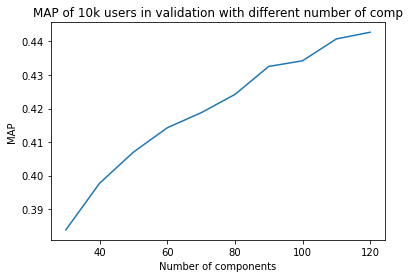

In [5]:
plt.plot(figsize=(10,8))
df_K = pd.DataFrame.from_dict(scores,orient='index',columns=['score'])
plt.plot(df_K)
plt.xlabel('Number of components')
plt.ylabel('MAP')
plt.title('MAP of 10k users in validation with different number of comp')
plt.savefig(os.path.join('pic','MAP-vs-n_components.png'),dpi=100)

In [29]:
perf = [
    [30,0.001,0,0.3838530568711836],
    [30,0.001,0.2,0.3834216463085362],
    [30,0.001,0.5,0.38328873499649274],
    
    [30,0.01,0,0.38386781729990266],
    [30,0.01,0.2,0.38296019084788424],
    [30,0.01,0.5,0.38261683761706977],
    
    [30,0.1,0,0.38381543034283117],
    [30,0.1,0.2,0.38132517643927216],
    [30,0.1,0.5,0.3801373836066885],

    [40,0.001,0,0.39769397589404576],
    [40,0.001,0.2,0.39765827245380775],
    [40,0.001,0.5,0.39733092225232],
    
    [40,0.01,0,0.3976832362272717],
    [40,0.01,0.2,0.3966498874646423],
    [40,0.01,0.5,0.39549411360199327],
    
    [40,0.1,0,0.3977354102426744],
    [40,0.1,0.2,0.39383432293266013],
    [40,0.1,0.5,0.3937354604329187],
    
    [50,0.001,0,0.4070688806812189],
    [50,0.001,0.2,0.4068394529437205],
    [50,0.001,0.5,0.40661607316529624],
    
    [50,0.01,0,0.40707177721696214],
    [50,0.01,0.2,0.40635828394043944],
    [50,0.01,0.5,0.4060968596860394],
    
    [50,0.1,0,0.40699910525135446],
    [50,0.1,0.2,0.40408993339454163],
    [50,0.1,0.5,0.40299009249364814],
    
    [60,0.001,0,0.4144738297649197],
    [60,0.001,0.2,0.4142497632165481],
    [60,0.001,0.5,0.4139262033106339],
    
    [60,0.01,0,0.4144805615652846],
    [60,0.01,0.2,0.4138007305026615],
    [60,0.01,0.5,0.4118120030872952],
    
    [60,0.1,0,0.41425620399348323],
    [60,0.1,0.2,0.4119791023858057],
    [60,0.1,0.5,0.4114175754098815],
    
    [70,0.001,0,0.4186935981855329],
    [70,0.001,0.2,0.41838512616677354],
    [70,0.001,0.5,0.41831090390268105],
    
    [70,0.01,0,0.41867645704250434],
    [70,0.01,0.2,0.4182060326185824],
    [70,0.01,0.5,0.4181642234963956],
    
    [70,0.1,0,0.4187344626270555],
    [70,0.1,0.2,0.41799522019327423],
    [70,0.1,0.5,0.41680781693498575],
]


In [31]:
df_perf = pd.DataFrame(perf, columns=['n_components','alpha','l1_ratio','MAP'])

Text(0.5, 1.0, 'MAP of 10k users in validation with different n_components')

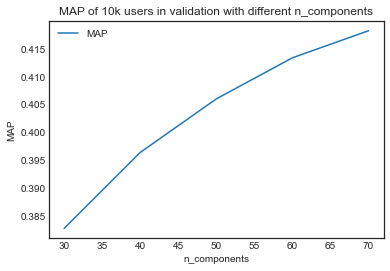

In [53]:
df_perf.iloc[:,[0,3]].groupby('n_components').mean().plot()
plt.xlabel('n_components')
plt.ylabel('MAP')
plt.title('MAP of 10k users in validation with different n_components')

Text(0.5, 1.0, 'MAP of 10k users in validation with different alpha')

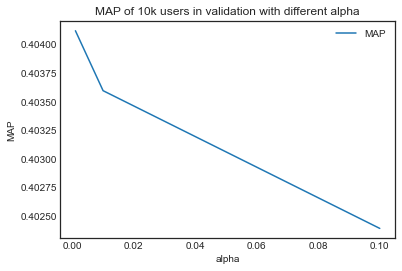

In [56]:
df_perf.iloc[:,[1,3]].groupby('alpha').mean().plot()
plt.xlabel('alpha')
plt.ylabel('MAP')
plt.title('MAP of 10k users in validation with different alpha')

Text(0.5, 1.0, 'MAP of 10k users in validation with different l1_ratio')

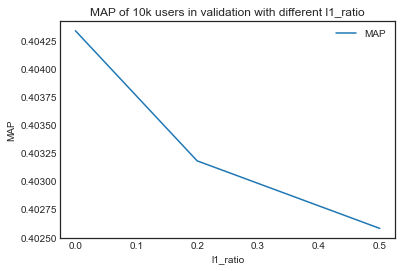

In [50]:
df_perf.iloc[:,[2,3]].groupby('l1_ratio').mean().plot()
plt.xlabel('l1_ratio')
plt.ylabel('MAP')
plt.title('MAP of 10k users in validation with different l1_ratio')

In [44]:
nmf()

,MAP
l1_ratio,
0.0,0.404340
0.2,0.403184
0.5,0.402583
